<a href="https://colab.research.google.com/github/wallykop/iad-deep-learning/blob/master/4_cnn_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар 4: ` Keras` и сверточные нейронные сети

На семинаре мы при помощи библиотеки `keras` обучим глубокую сверточную нейронную сеть.

Библиотека `keras` — надстройка над фреймворками [Tensorflow](https://www.tensorflow.org/), [Theano](http://deeplearning.net/software/theano/), [CNTK](https://docs.microsoft.com/en-us/cognitive-toolkit/). Можно использовать в качестве бэкенда любой из этих фреймворков, и код будет исполняться независмо от выбранного бэкенда. По умолчанию `keras` работает с `tensorflow`.

In [0]:
import keras
keras.backend.backend()


Using TensorFlow backend.


'tensorflow'

In [0]:
import tensorflow as tf
from keras import backend as K

# соответствует tf.placeholder() или th.tensor.matrix(), th.tensor.tensor3(), и т. д. в зависимости от бэкенда
inputs = K.placeholder(shape=(2, 4, 5))
inputs = K.placeholder(shape=(None, 4, 5))
inputs = K.placeholder(ndim=3)

# делать операции над тензорами можно как мы привыкли с tensorflow
b = K.random_uniform_variable(shape=(4, 5), low=0, high=1)
c = K.random_normal_variable(shape=(4, 5), mean=0, scale=1)

a = b + c * K.abs(b)
c = K.dot(a, K.transpose(b))
d = K.sum(b, axis=1)
b = K.concatenate([b, c], axis=-1)

# в результате операций над тензорами получили неинициализированный тензор, как и для tensorflow
print(c, "\n")

# а теперь посчитаем, чему будут равны тензоры для конкретных входных данных
print("c: \n", K.eval(c))
print("d: \n", K.eval(d))
print("b: \n", K.eval(b))

K.clear_session()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Tensor("MatMul:0", shape=(4, 4), dtype=float32) 







c: 
 [[1.7405376  1.3679346  0.67915016 1.9584877 ]
 [2.093558   2.6865113  0.94803894 3.0186367 ]
 [1.2936199  0.5391528  0.626304   1.375074  ]
 [2.6833124  2.4474635  1.2534574  3.5627022 ]]
d: 
 [3.273085  2.6198401 1.4744264 3.8919153]
b: 
 [[0.9466393  0.2774688  0.80340433 0.4097756  0.83579695 1.7405376
  1.3679346  0.67915016 1.9584877 ]
 [0.2009983  0.7987126  0.5868274  0.7476045  0.28569746 2.093558
  2.6865113  0.94803894 3.0186367 ]
 [0.30904436 0.03046417 0.27749264 0.3448565  0.5125687  1.2936199
  0.5391528  0.626304   1.375074  ]
 [0.63196576 0.6573322  0.90178025 0.7444222  0.95641494 2.6833124
  2.4474635  1.2534574  3.5627022 ]]





# Keras Sequential API
Основная структура данных в `Keras` —  это  `model`, способ организовать слои в нейронной сети. Простейший способ создать модель — использовать `Sequential()`. Такая модель представляет из себя стек слоев, идущих последовательно друг за другом, именно такой моделью мы и будем сегодня пользоваться для обучения сверточной нейронной сети.

In [0]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

model = Sequential()

# для первого слоя  в последовательности нужно указать размерности входных данных
# для других слоев делать это уже не нужно
model.add(Dense(32, activation='relu', input_dim=100))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='softmax'))

# компилируем модель, определяем функцию потерь, метрику качества, метод оптимизации
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

import numpy as np
data = np.random.random((1000, 100))
labels = np.random.randint(10, size=(1000, 1))

one_hot_labels = to_categorical(labels, num_classes=10)

# обучаем модель, указываем количество шагов градиентного спуска, размер батча
model.fit(data, one_hot_labels, epochs=10, batch_size=32, verbose=0)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# Keras Callbacks
Callbacks — это набор функций, которые можно передать в процедуру обучения модели. Можно использовать колбэки, чтобы следить за метриками во время обучения, что может быть полезно для дебага, сохранять модель и так далее. Список колбэков передается в `.fit()`, релевантные колбэки вызываются на каждой итерации обучения.

В `keras` реализовано [много полезных колбэков](https://keras.io/callbacks/), так же есть возможность писать кастомные.

In [0]:
# определим кастомный колбэк, который выводит функции потерь для каждого батча на каждой итерации
class LossHistory(keras.callbacks.Callback):        
    def on_epoch_begin(self, epoch, logs={}):
        # в self.losses будем хранить искомый список функций потерь для батчей, надо его инициализировать
        # еще можно номер итерации вывести
        ### YOUR CODE HERE
        self.losses = []
        print("Epoch:", epoch)
        
    def on_epoch_end(self, epoch, logs={}):
        # выполнили один шаг градиентного спуска, самое время вывести вычисленные функции потерь
        ### YOUR CODE HERE        
        print("Batch loses:", self.losses)
        print("Loss: ", logs.get('loss'))

    def on_batch_end(self, batch, logs={}):
        # закончили обрабатывать батч, надо сохранить лосс, он лежит в logs.get('loss')
        ### YOUR CODE HERE        
        self.losses.append(logs.get('loss'))

history = LossHistory()
model.fit(data,
          one_hot_labels,
          epochs=10,
          batch_size=200,
          verbose=0,
          callbacks=[keras.callbacks.EarlyStopping(monitor='loss'), # добавим еще EarlyStopping, реализованный в keras
                     history]
         )

Epoch: 0
Batch loses: [2.2571464, 2.2684946, 2.2282598, 2.2428925, 2.2495544]
Loss:  2.2492695331573485
Epoch: 1
Batch loses: [2.2250998, 2.2190242, 2.2375982, 2.2633257, 2.2589195]
Loss:  2.240793466567993
Epoch: 2
Batch loses: [2.2329218, 2.2525048, 2.225378, 2.2351682, 2.2409093]
Loss:  2.2373764514923096
Epoch: 3
Batch loses: [2.2375598, 2.222759, 2.2290838, 2.2430515, 2.251126]
Loss:  2.2367160320281982
Epoch: 4
Batch loses: [2.2109826, 2.2321131, 2.2455409, 2.2426643, 2.2356894]
Loss:  2.2333980560302735
Epoch: 5
Batch loses: [2.2375534, 2.2402658, 2.220403, 2.2269478, 2.2259562]
Loss:  2.2302252292633056
Epoch: 6
Batch loses: [2.1968415, 2.2211952, 2.242487, 2.2432342, 2.2488625]
Loss:  2.2305240631103516


# Сверточная нейронная сеть для CIFAR-10

Датасет CIFAR-10 содержит цветные картинки 32x32, каждая из которых принадлежит одному из 10 классов: __airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__

В задании нужно будет:
* Определить архитектуру CNN
* Обучить модель
* Визуализировать обученные фильтры


**ОБРАТИТЕ ВНИМАНИЕ:** обучение CNN на CPU для этого задания может занимать достаточно много времени, 0.5-1.5 часа, поэтому будем обучать модель на GPU

**Runtime -> Change runtime type** и выберите **GPU** в Google Colab


In [0]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

1.15.0
2.2.5


In [0]:
# чистим сессию, чтобы не получить out-of-memory
def reset_tf_session():
    curr_session = tf.get_default_session()
    if curr_session is not None:
        curr_session.close()
    K.clear_session()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

# Загрузка датасета

In [0]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [0]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

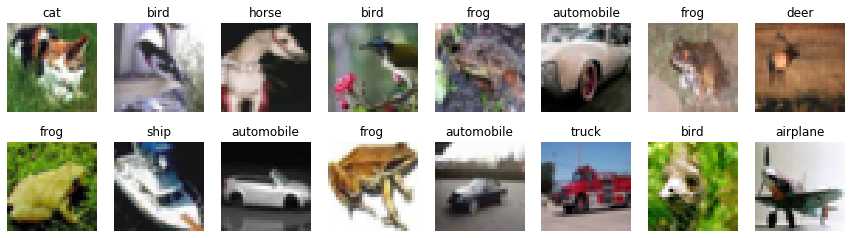

In [0]:
# посмотрим на случайные картинки из датасета
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Нормализация данных
Как мы знаем, нейронные сети любят, когда входные данные нормализованы, нормализуем их: $$x_{norm} = \frac{x}{255} - 0.5$$

Так же нужно преобразовать классы в one-hot encoded векторы с помощью __keras.utils.to_categorical__.

In [0]:
# нормализуем входные данные
x_train2 = x_train / 255 - 0.5 ### YOUR CODE HERE
x_test2 = x_test / 255 - 0.5 ### YOUR CODE HERE

# преобразуем метки классов в one-hot encoded векторы, должно получиться(?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train, 10) ### YOUR CODE HERE
y_test2 = keras.utils.to_categorical(y_test, 10) ### YOUR CODE HERE

# Архитектура CNN

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

Сверточные нейронные сети строятся из нескольких типов слоев:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - свертка:
    - **filters**: количество выходных каналов; 
    - **kernel_size**: ширина и высота окна для свертки, tuple/list из двух целых чисел;
    - **padding**: padding="same" добавляет столько нулей, чтобы выходной канал имел такие же размеры, как и вход, при padding='valid' свертка выполняется только там, где ядро свертки полностью пересекается с входным каналом;
    - **activation**: "relu", "tanh", и т.д.
    - **input_shape**: размерности входных данных.
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - выполняет 2D max pooling.
- [Flatten](https://keras.io/layers/core/#flatten) - не затрагивает размерность,  соответствующую размеру батча.
- [Dense](https://keras.io/layers/core/#dense) - полносвязный слой.
- [Activation](https://keras.io/layers/core/#activation) - применяет функцию активации.
- [LeakyReLU](https://keras.io/layers/advanced-activations/#leakyrelu) - применяет функцию активации leaky relu.
- [Dropout](https://keras.io/layers/core/#dropout) - применяет dropout.

Размерность входных данных для модели __(None, 32, 32, 3)__ , размерность выходных __(None, 10)__ . __None__ соответствует размерности размера батча.

Шаблон модели:

```python
model = Sequential() 
model.add(Conv2D(..., input_shape=(32, 32, 3)))  # не забываем определить размерность входа для первого слоя

...  # сверточные слои, пулинг, дропаут

model.add(Dense(NUM_CLASSES))  
model.add(Activation("softmax"))
```

In [0]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    
    model = Sequential()
    model.add(Conv2D(filters=16, padding='same', kernel_size=(3,3), input_shape=(32,32,3)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters=32, padding='same', kernel_size=(3,3)))  
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=32, padding='same', kernel_size=(3,3)))  
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters=64, padding='same', kernel_size=(3,3)))  
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same')) 
    model.add(Dropout(0.25)) 
    model.add(Flatten())
    model.add(Dense(256))                
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))    
    model.add(Dense(10))             
    model.add(Activation("softmax"))
    
    return model


In [0]:
s = reset_tf_session()
model = make_model()
model.summary()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
___

# Обучение модели

На GPU 10-20 секунд на эпоху.
Добавим в обучение уменьшение learning rate с номером эпохи при помощи callback

In [0]:
INIT_LR = 5e-3  # стартовый learning rate
BATCH_SIZE = 32
EPOCHS = 10

s = reset_tf_session()

model = make_model()

# определите функцию потреть, метод оптимизации и метрику качества
### YOUR CODE HERE
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# формула, по которой будет меняться learning rate в зависимости от эпохи, передадим ее в LearningRateScheduler callback
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# будем выводить актуальный learning rate в начале каждой итерации (on_epoch_begin)
# для этого нужно написать кастомный callback
class LrHistory(keras.callbacks.Callback):
    ### YOUR CODE HERE
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

In [0]:
# обучаем модель
model.fit(
    x_train2, y_train2,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory(),],
    validation_data=(x_test2, y_test2),
    shuffle=True,
    verbose=1,
    initial_epoch=0    
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/10
Learning rate: 0.005
50000/50000 [==============================] - 29s 574us/step - loss: 1.3714 - acc: 0.5064 - val_loss: 0.9943 - val_acc: 0.6483
Epoch 2/10
Learning rate: 0.0045
50000/50000 [==============================] - 24s 478us/step - loss: 0.9744 - acc: 0.6591 - val_loss: 0.8188 - val_acc: 0.7103
Epoch 3/10
Learning rate: 0.00405
50000/50000 [==============================] - 25s 496us/step - loss: 0.8295 - acc: 0.7099 - val_loss: 0.7480 - val_acc: 0.7403
Epoch 4/10
Learning rate: 0.003645
50000/50000 [==============================] - 25s 492us/step - loss: 0.7388 - acc: 0.7419 - val_loss: 0.7086 - val_acc: 0.7555
Epoch 5/10
Learning rate: 0.0032805
50000/50000 [==============================] - 24s 489us/step - loss: 0.6764 - acc: 0.7629 - val_loss: 0.6659 - val_acc: 0.7654
Epoch 6/10
Learning rate: 0.00295245
50000/5

In [0]:
# сохраняем веса модели
model.save_weights("weights.h5")

In [0]:
# загружаем веса (можно не вызывать model.fit, если модель была однажды обучена и веса сохранены)
model.load_weights("weights.h5")

# Применение модели

In [0]:
# вычисляем прогноз для тестовых данных
y_pred_test = model.predict_proba(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

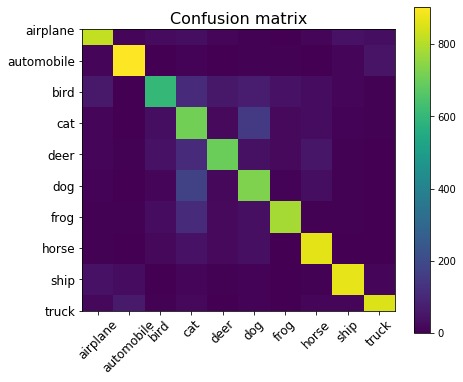

Test accuracy: 0.7837


In [0]:
# матрица ошибок и точность
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

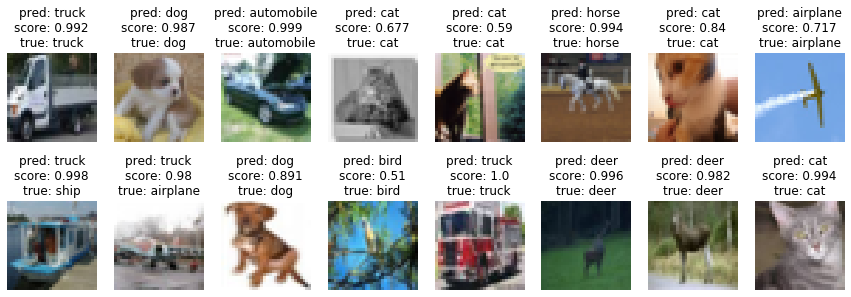

In [0]:
# посмотрим на предсказания
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.axis("off")
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index, 0]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Визуализация фильтров

Мы хотим найти входные изображения, максимизирующие активации для заданного слоя нейронной сети.

Задача очень похожа на задачу обучения весов для нейронной сети: при обучении весов нам нужно найти веса, минимизирующие функцию потерь, для данного входного изображения. Решаем эту задачу градиентным спуском, ищем градиент функции потерь по весам.

Теперь мы хотим найти входное изображение, максимизирующее среднее значение активации на заданном слое
$$Loss(layer) = Mean(layer) = \frac{1}{|layer|}\sum_{x \in layer}x \rightarrow \max    $$

Задачи максимизации решаются аналогично задачам минимизации с помощью градиентного подъема

$$image_{t+1} = Image_t + \gamma\frac{\partial  Loss}{\partial   Image_t}$$


In [0]:
s = reset_tf_session()
K.set_learning_phase(0)
model = make_model()
model.load_weights("weights.h5")  # веса сохранены после обучения model.fit

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)       

In [0]:
def find_maximum_stimuli(layer_name, is_conv, filter_index, model, iterations=20, step=1., verbose=True):
    
    def image_values_to_rgb(x):
        # нормализуем x: центрируем в 0 (np.mean(x_train2)), убедиться, что std=0.25 (np.std(x_train2))
        # теперь х такой же как нормализованный вход нейронной сети
        x = (x - np.mean(x)) / np.std(x) / 4 ### YOUR CODE HERE        

        # преобразуем нормализованный вход обратно к RGB: x = (x_norm + 0.5) * 255
        x = (x + 0.5) * 255 ### YOUR CODE HERE
    
        x = np.clip(x, 0, 255).astype('uint8')
        return x

    # placeholder для входного изображения
    input_img = model.input
    img_width, img_height = input_img.shape.as_list()[1:3]
    
    # находим выходы заданного слоя
    layer_output = list(filter(lambda x: x.name == layer_name, model.layers))[0].output
    
    # определите функцию потерь, обратите внимание, что мы можем считать ее 
    # как для сверточного слоя, так и для полносвязного
    ### YOUR CODE HERE
    if is_conv:
        loss = K.mean(layer_output[:, :, :, filter_index])
    else:
        loss = K.mean(layer_output[:, filter_index])    

    # посчитайте градиент функции потерь по входному изображению с помощью  K.gradients
    ### YOUR CODE HERE
    grads = K.gradients(loss, input_img)[0]

    # normalization trick
    grads = grads / (K.sqrt(K.sum(K.square(grads))) + 1e-10)

    # считаем градиенты за одну итерацию
    iterate = K.function([input_img], [loss, grads])

    # инициализируем входное ихображение: серое изображение со случайным шумом
    input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * (0.1 if is_conv else 0.001)

    # градиентный подъем
    for i in range(iterations):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        if verbose:
            print('Current loss value:', loss_value)

    # преобразуем изображение в RGB формат
    img = image_values_to_rgb(input_img_data[0])
    
    return img, loss_value

In [0]:
# sample maximum stimuli
def plot_filters_stimuli(layer_name, is_conv, model, iterations=20, step=1., verbose=False):
    cols = 8
    rows = 2
    filter_index = 0
    max_filter_index = list(filter(lambda x: x.name == layer_name, model.layers))[0].output.shape.as_list()[-1] - 1
    fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
    for i in range(cols):
        for j in range(rows):
            if filter_index <= max_filter_index:
                ax = fig.add_subplot(rows, cols, i * rows + j + 1)
                ax.grid(False)
                ax.axis('off')
                loss = -1e20
                while loss < 0 and filter_index <= max_filter_index:
                    stimuli, loss = find_maximum_stimuli(layer_name, is_conv, filter_index, model,
                                                         iterations, step, verbose=verbose)
                    filter_index += 1
                if loss > 0:
                    ax.imshow(stimuli)
                    ax.set_title("Filter #{}".format(filter_index))
    plt.show()

leaky_re_lu_1


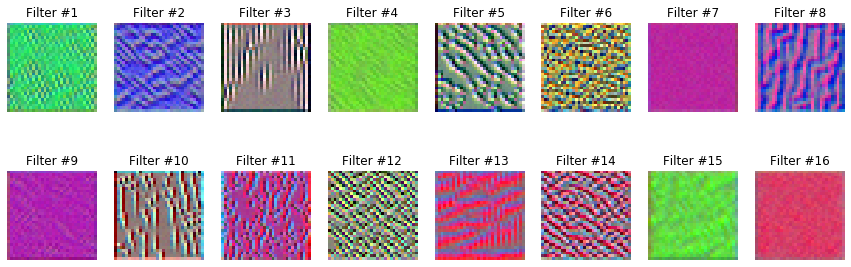

leaky_re_lu_2


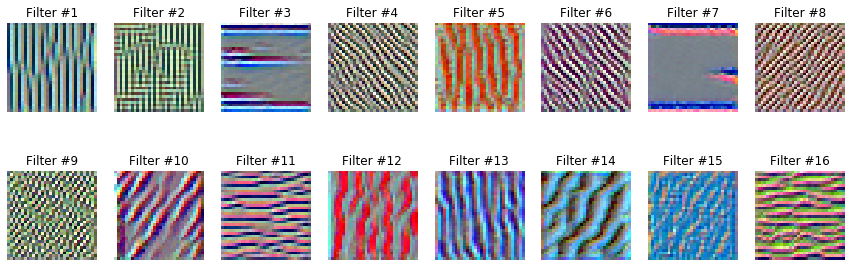

leaky_re_lu_3


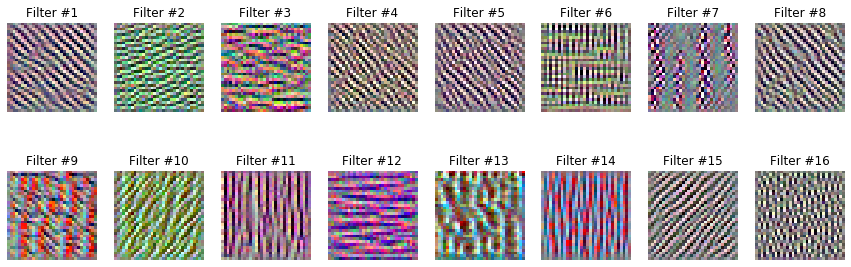

leaky_re_lu_4


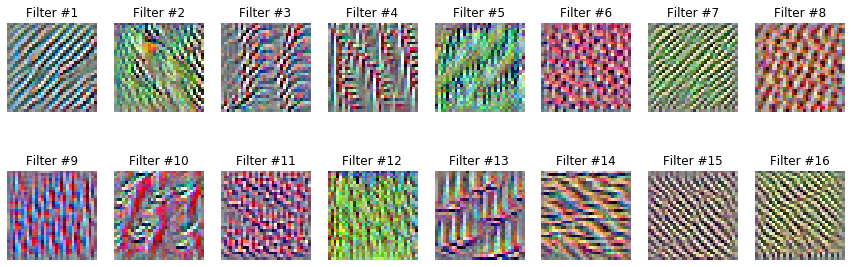

In [0]:
# maximum stimuli for convolutional neurons
conv_activation_layers = []
for layer in model.layers:
    if isinstance(layer, LeakyReLU):
        prev_layer = layer._inbound_nodes[0].inbound_layers[0]
        if isinstance(prev_layer, Conv2D):
            conv_activation_layers.append(layer)

for layer in conv_activation_layers:
    print(layer.name)
    plot_filters_stimuli(layer_name=layer.name, is_conv=True, model=model)

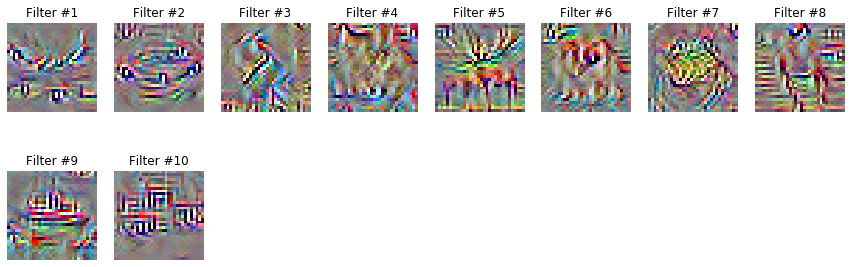

In [0]:
# maximum stimuli for last dense layer
last_dense_layer = list(filter(lambda x: isinstance(x, Dense), model.layers))[-1]
plot_filters_stimuli(layer_name=last_dense_layer.name, is_conv=False, 
                     iterations=200, step=0.1, model=model)